In [1]:
import os
import glob
import numpy as np
import pandas as pd
import radio
from radio.batchflow import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch as CTIMB
from radio_utils import show_slices, get_nodules_pixel_coords, num_of_cancerous_pixels
from radio.pipelines import split_dump

from config import config
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [32, 32]

# import utils
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/paul/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
PATH_TO_FOLDER = config['luna_raw']
cancerous_folder, non_cancerous_folder = '../jfr_pp/test/positive32', '../jfr_pp/test/negative32'
luna_label = config['luna_label']
    
path_to_scans_sample = os.path.join(PATH_TO_FOLDER, '*.mhd')
luna_index = FilesIndex(path=path_to_scans_sample, no_ext=True)
lunaset = Dataset(index=luna_index, batch_class=CTIMB)
print(len(luna_index.indices))
lunaset.split([0.8,0.1,0.1])
print(len(lunaset.train))

884
708


In [3]:
# print(lunaset.train.indices)
# ['1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.211051626197585058967163339846'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543'
#  '1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785']

In [3]:
nodules_df = pd.read_csv(luna_label)
print(nodules_df.head(2))

                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  


In [4]:
SPACING = (1.0, 1.0, 1.0)  # spacing of scans after spacing unification
# SHAPE = (400, 512, 512)  # shape of scans after spacing unification
PADDING = 'reflect'  # 'reflect' padding-mode produces the least amount of artefacts
METHOD = 'pil-simd'  # robust resize-engine

kwargs_default = dict(spacing=SPACING, padding=PADDING, method=METHOD)

crops_dumping = split_dump(cancerous_folder, non_cancerous_folder, nodules_df, 
                           fmt='raw', nodule_shape=(32,64,64),variance=(16,36,36), **kwargs_default)

In [5]:
%%time

(lunaset.train >> crops_dumping).run()
print(len(os.listdir(cancerous_folder)), len(os.listdir(non_cancerous_folder)))

93300 91670
CPU times: user 3h 25min 44s, sys: 35min 36s, total: 4h 1min 21s
Wall time: 1h 28min 57s


In [6]:
print(len(os.listdir(cancerous_folder)), len(os.listdir(non_cancerous_folder)))

93300 91670


In [7]:
cancer_index = FilesIndex(path=os.path.join(cancerous_folder, '*'), dirs=True)
non_cancer_index = FilesIndex(path=os.path.join(non_cancerous_folder, '*'), dirs=True)
cancer_set = Dataset(cancer_index, batch_class=CTIMB)
non_cancer_set = Dataset(non_cancer_index, batch_class=CTIMB)

In [8]:
from radio.pipelines import combine_crops
crops_sampling = combine_crops(cancer_set, non_cancer_set, batch_sizes=(5, 5))

In [9]:
np.random.seed(42)
batch_crops = crops_sampling.next_batch()
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7,Scan 8,Scan 9
Number of cancerous pixels:,0,0,0,0,0,280,1331,6923,216,64


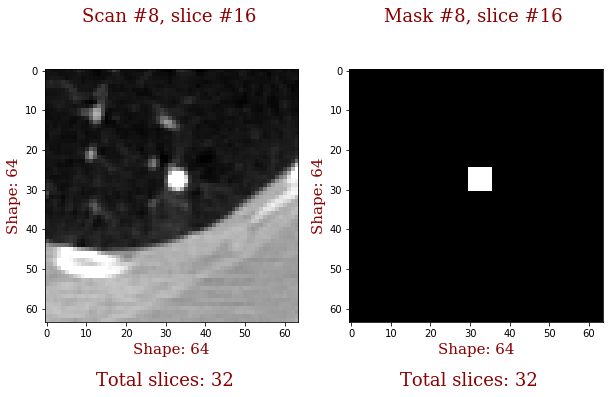

In [10]:
show_slices(batch_crops, 8, 16, components=['images', 'masks'], clims=[(0, 255), (0, 1)],
            grid=False)

In [27]:
test = batch_crops.get(8, 'masks')
np.where(test[:]>0)

(array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]),
 array([37, 37, 37, 37, 37, 37